# Implemented Clarans

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt


class CLARANS:
    def __init__(self, num_clusters, max_neighbors, num_local, distance_metric="euclidean"):
        """
        Initialize the CLARANS algorithm.

        Parameters:
            num_clusters: Number of clusters (k).
            max_neighbors: Maximum number of neighbors to explore.
            num_local: Number of local search trials.
            distance_metric: Distance metric ("euclidean" or "manhattan").
        """
        self.num_clusters = num_clusters
        self.max_neighbors = max_neighbors
        self.num_local = num_local
        self.distance_metric = distance_metric

    def compute_distance(self, point1, point2):
        """Calculate distance between two points."""
        if self.distance_metric == "euclidean":
            return np.sqrt(np.sum((point1 - point2) ** 2))
        elif self.distance_metric == "manhattan":
            return np.sum(np.abs(point1 - point2))
        else:
            raise ValueError("Unsupported distance metric.")

    def assign_to_clusters(self, data, medoids):
        """Assign each data point to the nearest medoid."""
        clusters = {i: [] for i in range(len(medoids))}
        cost = 0
        
        for point in data:
            distances = [self.compute_distance(point, medoid) for medoid in medoids]
            nearest_medoid = np.argmin(distances)
            clusters[nearest_medoid].append(point)
            cost += distances[nearest_medoid]

        return clusters, cost

    def find_best_medoid(self, cluster_points, current_medoid):
        """Find the best medoid for a given cluster."""
        min_cost = float("inf")
        best_medoid = current_medoid

        for candidate_medoid in cluster_points:
            cost = sum(self.compute_distance(candidate_medoid, point) for point in cluster_points)
            if cost < min_cost:
                min_cost = cost
                best_medoid = candidate_medoid

        return best_medoid

    def fit(self, data):
        """
        Run the CLARANS algorithm on the data.

        Parameters:
            data: Data to be clustered, in numpy.ndarray format.

        Returns:
            A tuple containing the final clusters and the final medoids.
        """
        best_medoids = None
        best_cost = float("inf")
        best_clusters = None

        for _ in range(self.num_local):
            # Randomly initialize the medoids
            medoids_indices = random.sample(range(len(data)), self.num_clusters)
            medoids = [data[idx] for idx in medoids_indices]

            improved = True
            while improved:
                improved = False
                current_clusters, current_cost = self.assign_to_clusters(data, medoids)
                
                # Explore neighbors
                for _ in range(self.max_neighbors):
                    # Randomly select a medoid and an alternative
                    medoid_idx = random.choice(range(len(medoids)))
                    alternative_idx = random.choice([i for i in range(len(data)) if i not in medoids_indices])
                    alternative_medoid = data[alternative_idx]

                    # Create a new set of medoids
                    new_medoids = medoids[:]
                    new_medoids[medoid_idx] = alternative_medoid

                    # Compute the cost for the new medoids
                    _, new_cost = self.assign_to_clusters(data, new_medoids)

                    if new_cost < current_cost:
                        medoids = new_medoids
                        medoids_indices[medoid_idx] = alternative_idx
                        current_cost = new_cost
                        improved = True
                        break

            # Update if a better local solution is found
            if current_cost < best_cost:
                best_medoids = medoids
                best_cost = current_cost
                best_clusters = current_clusters

        return best_clusters, best_medoids

In [22]:
data = pd.read_csv('part2_final.csv')

In [23]:
columns_to_use = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
data_for_clustering = data[columns_to_use].values

# Apply the CLARANS algorithm
clarans = CLARANS(num_clusters=4, max_neighbors=5, num_local=3, distance_metric="euclidean")

# Mesurer le temps d'exécution pour l'entraînement
start_time = time.time()

clusters, medoids = clarans.fit(data_for_clustering)

medoid_sauv = medoids

end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time:.4f} secondes") 

Temps d'entraînement : 3.1929 secondes


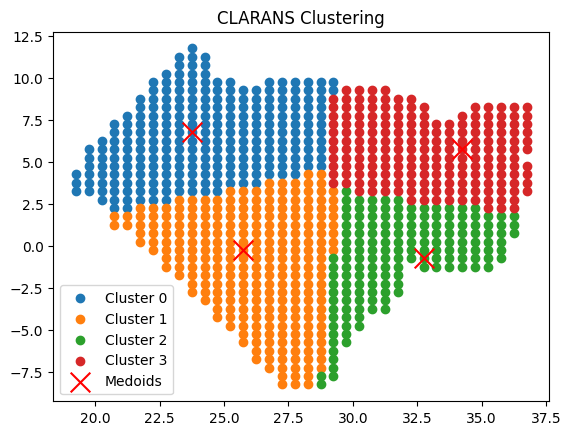

In [24]:
for cluster_idx, points in clusters.items():
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster_idx}")

# Mark the medoids in the plot
medoids = np.array(medoids)
plt.scatter(medoids[:, 0], medoids[:, 1], color="red", marker="x", s=200, label="Medoids")

plt.legend()
plt.title("CLARANS Clustering")
plt.show()

In [29]:
# Calcul du MSE pour chaque cluster
mse_values = []
for cluster_idx, cluster_points in clusters.items():
    cluster_points = np.array(cluster_points, dtype=int)  # Convert to integer indices
    cluster_data = data_for_clustering[cluster_points]  # Access the cluster's points
    medoid = medoid_sauv[cluster_idx]  # Get the medoid for the current cluster
    
    # Calculer la distance entre chaque point et le médoïde
    distances = np.linalg.norm(cluster_data - medoid, axis=1)
    mse = np.mean(distances ** 2)  # Erreur quadratique moyenne pour le cluster
    mse_values.append(mse)

# MSE global (moyenne des MSE des clusters)
global_mse = np.mean(mse_values)
print(f"MSE global : {global_mse:.4f}")

# Affichage des MSE par cluster
for cluster_idx, mse in enumerate(mse_values):
    print(f"MSE pour le Cluster {cluster_idx} : {mse:.4f}")


MSE global : 90.9809
MSE pour le Cluster 0 : 11.1491
MSE pour le Cluster 1 : 55.5644
MSE pour le Cluster 2 : 154.6060
MSE pour le Cluster 3 : 142.6042


# Predefined Clarans

In [ ]:
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import read_sample
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.utils.metric import type_metric, distance_metric

# Nombre de clusters (k) et autres paramètres
num_clusters = 4
max_neighbors = 5
num_local = 3

# Définir la métrique pour le clustering
metric = distance_metric(type_metric.EUCLIDEAN)

# Initialisation des centres aléatoires (optionnel)
initial_centers = random_center_initializer(data_for_clustering, num_clusters).initialize()

# Mesurer le temps d'exécution pour l'entraînement
start_time = time.time()

# Application de CLARANS
clarans_instance = clarans(
    data_for_clustering, 
    num_clusters, 
    max_neighbors, 
    num_local
)

clarans_instance.process()

end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time:.4f} secondes")

# Récupérer les résultats
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

Temps d'entraînement : 130.3923 secondes


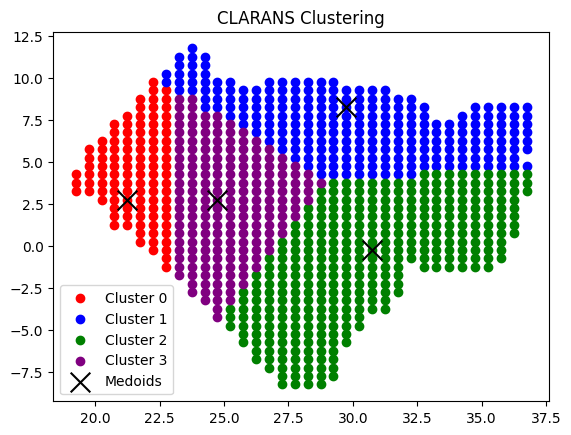

In [ ]:
# Affichage des clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']
for cluster_idx, cluster_points in enumerate(clusters):
    cluster_data = data_for_clustering[cluster_points]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[cluster_idx % len(colors)], label=f'Cluster {cluster_idx}')

# Marquer les médoines sur le graphique
medoid_data = data_for_clustering[medoids]
plt.scatter(medoid_data[:, 0], medoid_data[:, 1], color='black', marker='x', s=200, label='Medoids')

plt.legend()
plt.title('CLARANS Clustering')
plt.show()

In [ ]:
# Calcul du MSE pour chaque cluster
mse_values = []
for cluster_idx, cluster_points in enumerate(clusters):
    cluster_data = data_for_clustering[cluster_points]
    medoid = medoid_data[cluster_idx]
    
    # Calculer la distance entre chaque point et le médoïde
    distances = np.linalg.norm(cluster_data - medoid, axis=1)
    mse = np.mean(distances ** 2)  # Erreur quadratique moyenne pour le cluster
    mse_values.append(mse)

# MSE global (moyenne des MSE des clusters)
global_mse = np.mean(mse_values)
print(f"MSE global : {global_mse:.4f}")

# Affichage des MSE par cluster
for cluster_idx, mse in enumerate(mse_values):
    print(f"MSE pour le Cluster {cluster_idx} : {mse:.4f}")

MSE global : 15.6108
MSE pour le Cluster 0 : 10.7394
MSE pour le Cluster 1 : 18.5793
MSE pour le Cluster 2 : 20.9890
MSE pour le Cluster 3 : 12.1356
